In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import config
from Dataset import ColorzationDataset,ColorzationDatasetNew
from Generator import UNetResNet18
from Discriminator import Discriminator
from torch.utils.data import DataLoader
from tqdm import tqdm
from utils import generate_images
from loss import ColorizationLoss,HistLoss,PerceptualLoss
import torch.nn.functional as F
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
torch.backends.cudnn.benchmark = True

In [3]:
def train_fn(
    disc, gen, loader, opt_disc, opt_gen, bce, g_scaler, d_scaler,epoch,cl_loss,pr_loss
):
    loop = tqdm(loader, leave=True)

    for idx, (x, y) in enumerate(loop):
        x = x.to(config.DEVICE)
        y = y.to(config.DEVICE)


        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generator
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake).detach()
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            loss_cl = cl_loss(y_fake,y)
            # loss_pr = pr_loss(torch.cat([x,y_fake],1),torch.cat([x,y],1))
            # hist_loss = pr_loss(y_fake,y)
            G_loss = G_fake_loss + loss_cl 
            

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 10 == 0:
            generate_images(gen,'coco_dataset/2125.jpg')


            loop.set_postfix(
                G_loss=G_loss.item(),
                D_loss=D_loss.item(),
                epoch=epoch,
                current_lr=opt_gen.param_groups[0]['lr'],
            )

def pre_train_generator(gen, loader, opt_gen,epoch,cl_loss):
    loop = tqdm(loader, leave=True)
    for idx, (x, y) in enumerate(loop):
        x = x.to(config.DEVICE)
        y = y.to(config.DEVICE)

        preds = gen(x)
        
        loss = cl_loss(preds,y)
        opt_gen.zero_grad()
        loss.backward()
        opt_gen.step()
    
        if idx % 10 == 0:
            generate_images(gen,'coco_dataset/2125.jpg')
            loop.set_postfix(
                loss=loss.item(),
                epoch=epoch,
                current_lr=opt_gen.param_groups[0]['lr'],
            )

In [4]:
disc = Discriminator(input_channels=3,features=64).to(config.DEVICE)
gen = UNetResNet18(1,2).to(config.DEVICE)

gen.load_state_dict(torch.load(config.CHECKPOINT_GEN))
# disc.load_state_dict(torch.load(config.CHECKPOINT_DISC))


<All keys matched successfully>

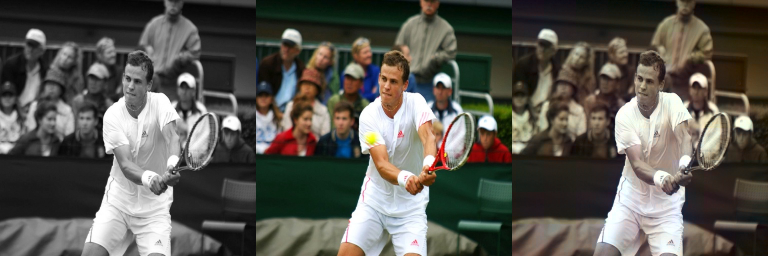

 40%|███▉      | 248/625 [01:22<01:45,  3.58it/s, current_lr=0.0001, epoch=13, loss=0.022]

In [5]:
opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.5, 0.999))
cl_loss = ColorizationLoss(0.1,1)

train_dataset = ColorzationDatasetNew(img_paths=config.TRAIN_DIR)
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=config.NUM_WORKERS,
)


for epoch in range(40):
    pre_train_generator(gen, train_loader, opt_gen,epoch,cl_loss)
    torch.save(gen.state_dict(), config.CHECKPOINT_GEN)

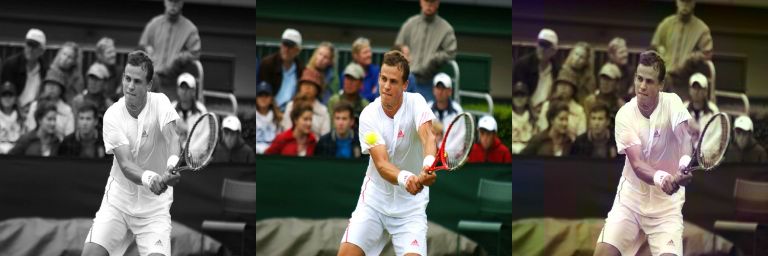

 59%|█████▉    | 369/625 [03:58<02:37,  1.63it/s, D_loss=0.625, G_loss=0.772, current_lr=0.0001, epoch=8]

In [ ]:
opt_disc = optim.Adam(disc.parameters(), lr=config.LEARNING_RATE, betas=(0.5, 0.999),)
opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.5, 0.999))
cl_loss = ColorizationLoss()
pr_loss = PerceptualLoss()
hist_loss = HistLoss()
BCE = nn.BCEWithLogitsLoss()

# train_dataset = ColorzationDataset(img_paths=config.TRAIN_DIR,max_length=10000)
train_dataset = ColorzationDatasetNew(img_paths=config.TRAIN_DIR)
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=config.NUM_WORKERS,
)

g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

for epoch in range(config.NUM_EPOCHS):
    train_fn(disc,gen,train_loader,opt_disc,opt_gen,BCE,g_scaler,d_scaler,epoch+1,cl_loss,hist_loss)
    # generate_images(gen,'dataset/audience-citizen_0.jpg')
    torch.save(disc.state_dict(), config.CHECKPOINT_DISC)
    torch.save(gen.state_dict(), config.CHECKPOINT_GEN)